# Predicting Diabetes

This dataset originally comes from the National Institute of Diabetes and Digestive and Kidney Diseases. The goal is to predict, based on diagnostic measures, whether or not a patient has diabetes

In [1]:
import logging 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve
from sklearn.tree import plot_tree
from sklearn.model_selection import ( train_test_split, GridSearchCV ) 
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, recall_score, f1_score, roc_auc_score
from sklearn.preprocessing import ( MinMaxScaler, LabelEncoder, StandardScaler, OneHotEncoder ) 
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import ( 
        accuracy_score, 
        f1_score, 
        matthews_corrcoef, 
        classification_report, 
        ConfusionMatrixDisplay ) 
from sklearn.inspection import permutation_importance
from sklearn.impute import SimpleImputer
import pickle
logger = logging.getLogger()
logger.setLevel(logging.INFO)


### **1. Data loading** **Objective**: Obtain the data from source and get a first glimpse of their properties and presentation

In [2]:
# https://raw.githubusercontent.com/4GeeksAcademy/decision-tree-project-tutorial/main/diabetes.csv
url = ('https://raw.githubusercontent.com/4GeeksAcademy/decision-tree-project-tutorial/main/diabetes.csv')
df_raw = pd.read_csv(url, sep=',')

# Mostrar las primeras filas del dataset para revisión
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


### **2. Data Preprocesing**
**Objective**: Perform the data cleaning, data information and data reduction steps to avoid data mistmatching, noisy data

In [3]:
df_baking = df_raw.copy()


In [4]:
df_baking.describe().T

,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.0,3.845052,3.369578,0.000,1.00000,3.0000,6.00000,17.00
Glucose,768.0,120.894531,31.972618,0.000,99.00000,117.0000,140.25000,199.00
BloodPressure,768.0,69.105469,19.355807,0.000,62.00000,72.0000,80.00000,122.00
SkinThickness,768.0,20.536458,15.952218,0.000,0.00000,23.0000,32.00000,99.00
Insulin,768.0,79.799479,115.244002,0.000,0.00000,30.5000,127.25000,846.00
BMI,768.0,31.992578,7.884160,0.000,27.30000,32.0000,36.60000,67.10
DiabetesPedigreeFunction,768.0,0.471876,0.331329,0.078,0.24375,0.3725,0.62625,2.42
Age,768.0,33.240885,11.760232,21.000,24.00000,29.0000,41.00000,81.00
Outcome,768.0,0.348958,0.476951,0.000,0.00000,0.0000,1.00000,1.00


In [5]:
df_baking.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [6]:
df_baking['Outcome'].value_counts(normalize=True)

Outcome
0    0.651042
1    0.348958
Name: proportion, dtype: float64

In [7]:
# Verificación de ceros en variables donde no deberían existir
zero_columns = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
df_baking[zero_columns].isin([0]).sum()

Glucose            5
BloodPressure     35
SkinThickness    227
Insulin          374
BMI               11
dtype: int64

In [8]:
# Reemplazar ceros por NaN en las columnas donde no deberían existir ceros
columns_to_replace = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
df_baking[columns_to_replace] = df_baking[columns_to_replace].replace(0, np.nan)

# Verificación de cuántos valores nulos hay ahora
df_baking.isnull().sum()

Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64

In [9]:
# Imputar valores nulos en 'Glucose', 'BloodPressure' y 'BMI' con la mediana de cada columna
columns_to_impute = ['Glucose', 'BloodPressure', 'BMI']
for col in columns_to_impute:
    median_value = df_baking[col].median()
    df_baking[col] = df_baking[col].fillna(median_value)

In [10]:
# Eliminar las columnas 'SkinThickness' e 'Insulin'
df_baking.drop(columns=['SkinThickness', 'Insulin'], inplace=True)

In [11]:
# Verificación final: revisar si todavía quedan nulos
df_baking.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [12]:
df=df_baking.copy()

### **3. Exploratory Data Analisys**
**Objective**: Sumarize the main characteristics of the dataset using descriptive statistics and data visualizations methods.

In [13]:
# Separar variables predictoras (X) y la variable objetivo (y)
X = df.drop('Outcome', axis=1)
y = df['Outcome']

# Realizar la división train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2,      # 20% para test
    random_state=42,    # para reproducibilidad
    stratify=y          # para mantener la proporción de clases
)

# Mostrar las dimensiones de los splits
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((614, 6), (154, 6), (614,), (154,))

In [14]:
# Unificar los conjuntos de entrenamiento y prueba
train_df = pd.concat([X_train, y_train], axis=1)
test_df = pd.concat([X_test, y_test], axis=1)

In [15]:
# Mostrar la forma de los conjuntos de entrenamiento y prueba
train_df.shape, test_df.shape

((614, 7), (154, 7))

In [16]:
# Mostrar las primeras filas del conjunto de entrenamiento
train_df.head()

,Pregnancies,Glucose,BloodPressure,BMI,DiabetesPedigreeFunction,Age,Outcome
353,1,90.0,62.0,27.2,0.580,24,0
711,5,126.0,78.0,29.6,0.439,40,0
373,2,105.0,58.0,34.9,0.225,25,0
46,1,146.0,56.0,29.7,0.564,29,0
682,0,95.0,64.0,44.6,0.366,22,0


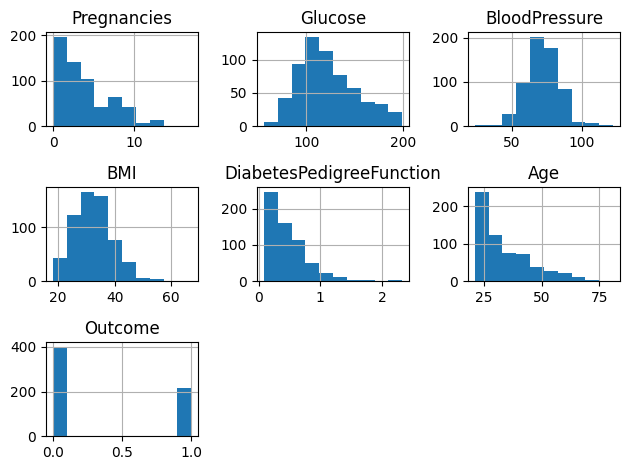

In [17]:
#Análisis Univariado
train_df.hist()
plt.tight_layout()
plt.show()

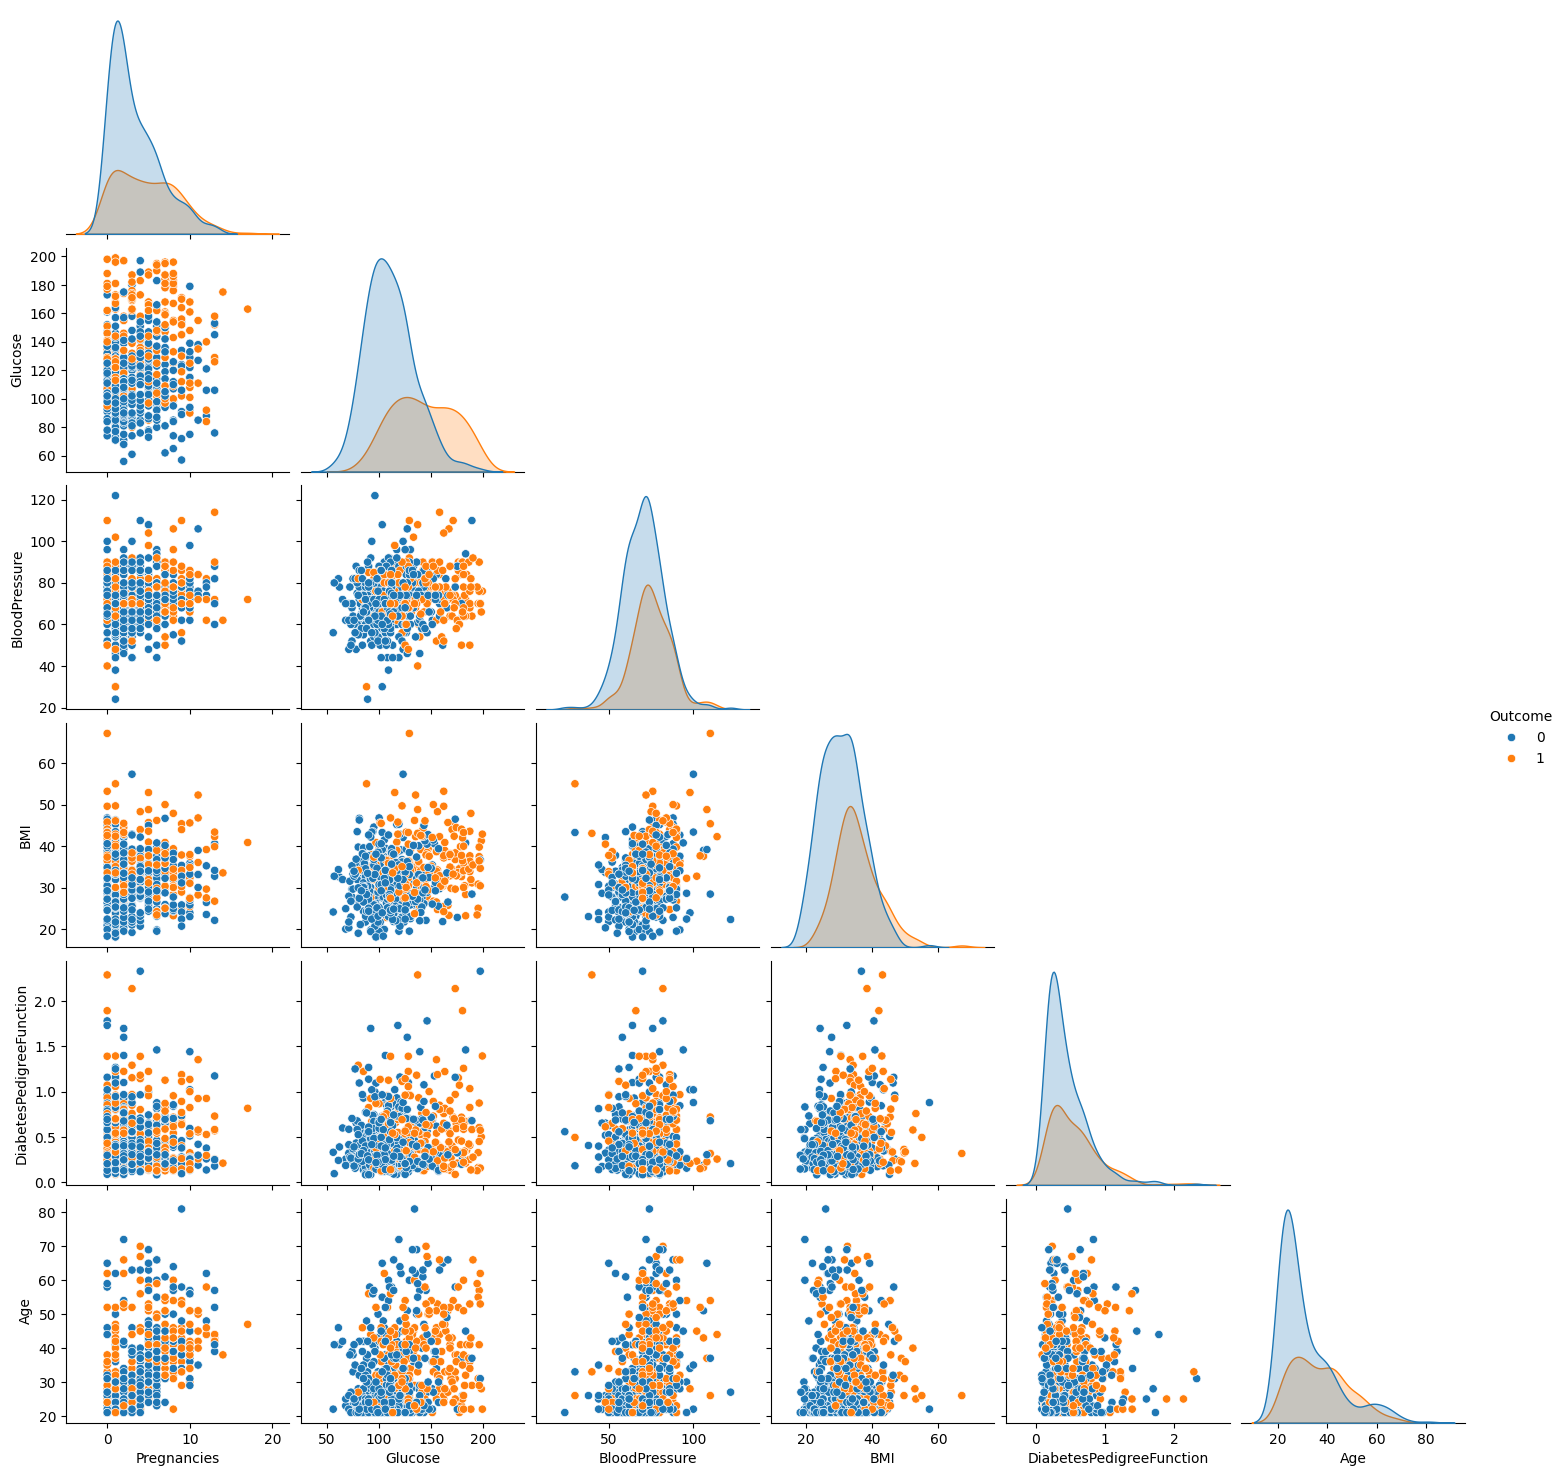

In [18]:
# análisis bivariado
sns.pairplot(train_df,hue = "Outcome", corner=True)
plt.show()


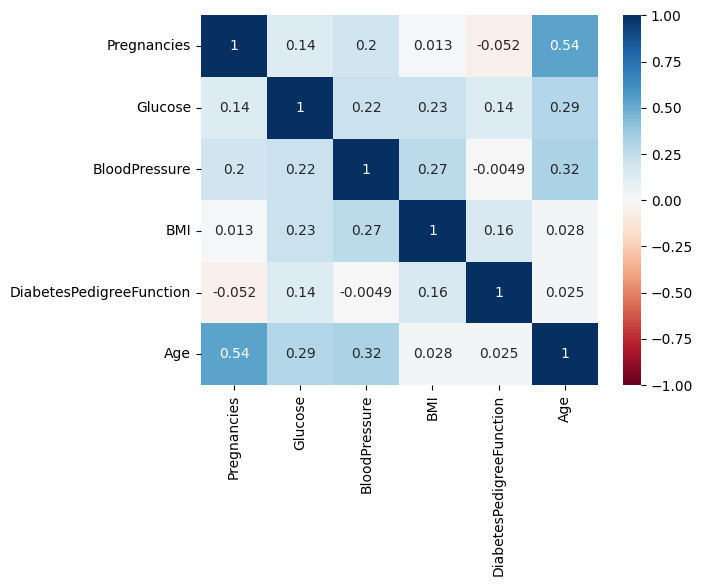

In [19]:
#Correlación
sns.heatmap(
    train_df.drop(columns=['Outcome']).corr(), 
    vmin=-1, vmax=1, annot=True, cmap='RdBu'
)
plt.show()


### **4. Machine learning** 
**Objective**: Create a model that learns from data to make predictions and generalize to unseen data, and thus perform tasks without explicit instructions

In [20]:
# Dividir el dataset en conjunto de entrenamiento y prueba
X_train = train_df.drop('Outcome', axis=1)
y_train = train_df['Outcome']
X_test = test_df.drop('Outcome', axis=1)
y_test = test_df['Outcome']

# Mostrar las dimensiones de los conjuntos de entrenamiento y prueba
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((614, 6), (154, 6), (614,), (154,))

In [21]:
# Mostrar las primeras filas del conjunto de entrenamiento
X_train.head()

,Pregnancies,Glucose,BloodPressure,BMI,DiabetesPedigreeFunction,Age
353,1,90.0,62.0,27.2,0.580,24
711,5,126.0,78.0,29.6,0.439,40
373,2,105.0,58.0,34.9,0.225,25
46,1,146.0,56.0,29.7,0.564,29
682,0,95.0,64.0,44.6,0.366,22


In [22]:
# Mostrar las primeras filas del conjunto de entrenamiento
y_train.head()

353    0
711    0
373    0
46     0
682    0
Name: Outcome, dtype: int64

In [23]:
clf_rforest_p = Pipeline([ 
('scaler', MinMaxScaler()), 
('rforest', RandomForestClassifier(class_weight='balanced', random_state=2025)) ])


In [24]:
clf_rforest_cv = GridSearchCV(
    clf_rforest_p,
    param_grid= {
        'rforest__n_estimators': [20,40,60,80,100,150,200],
        'rforest__criterion': ['gini', 'entropy'],
        'rforest__max_depth': [None,2, 3, 4, 5, 6, 7, 8, 9, 10],
    },
    cv=10,
    scoring='f1_weighted',
    n_jobs=3
)
clf_rforest_cv.fit(X_train, y_train)
clf_rforest_cv.best_params_


{'rforest__criterion': 'entropy',
 'rforest__max_depth': 5,
 'rforest__n_estimators': 20}

In [25]:
y_hat = clf_rforest_cv.best_estimator_.predict(X_test)
print(" Resultados del Modelo")
print("------------------------------")
print(f'accuracy: {accuracy_score(y_test, y_hat):.2f}')
print(f"f1_score: {f1_score(y_test, y_hat, average='weighted'):.2f}")
print(f'matthews_corrcoef: {matthews_corrcoef(y_hat, y_test):.2f}')
auc = roc_auc_score(y_test, y_hat)
print(f"Mean squared error: {mean_squared_error(y_test, y_hat)}")
print("------------------------------")


 Resultados del Modelo
------------------------------
accuracy: 0.73
f1_score: 0.73
matthews_corrcoef: 0.44
Mean squared error: 0.2727272727272727
------------------------------


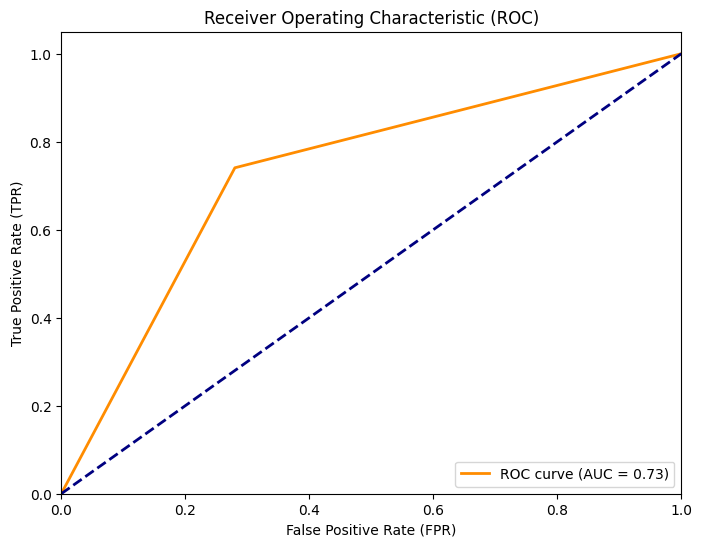

AUC: 0.73


In [26]:
# Calcular la curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_hat)

# Calcular el AUC
auc = roc_auc_score(y_test, y_hat)

# Graficar la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

print(f"AUC: {auc:.2f}")

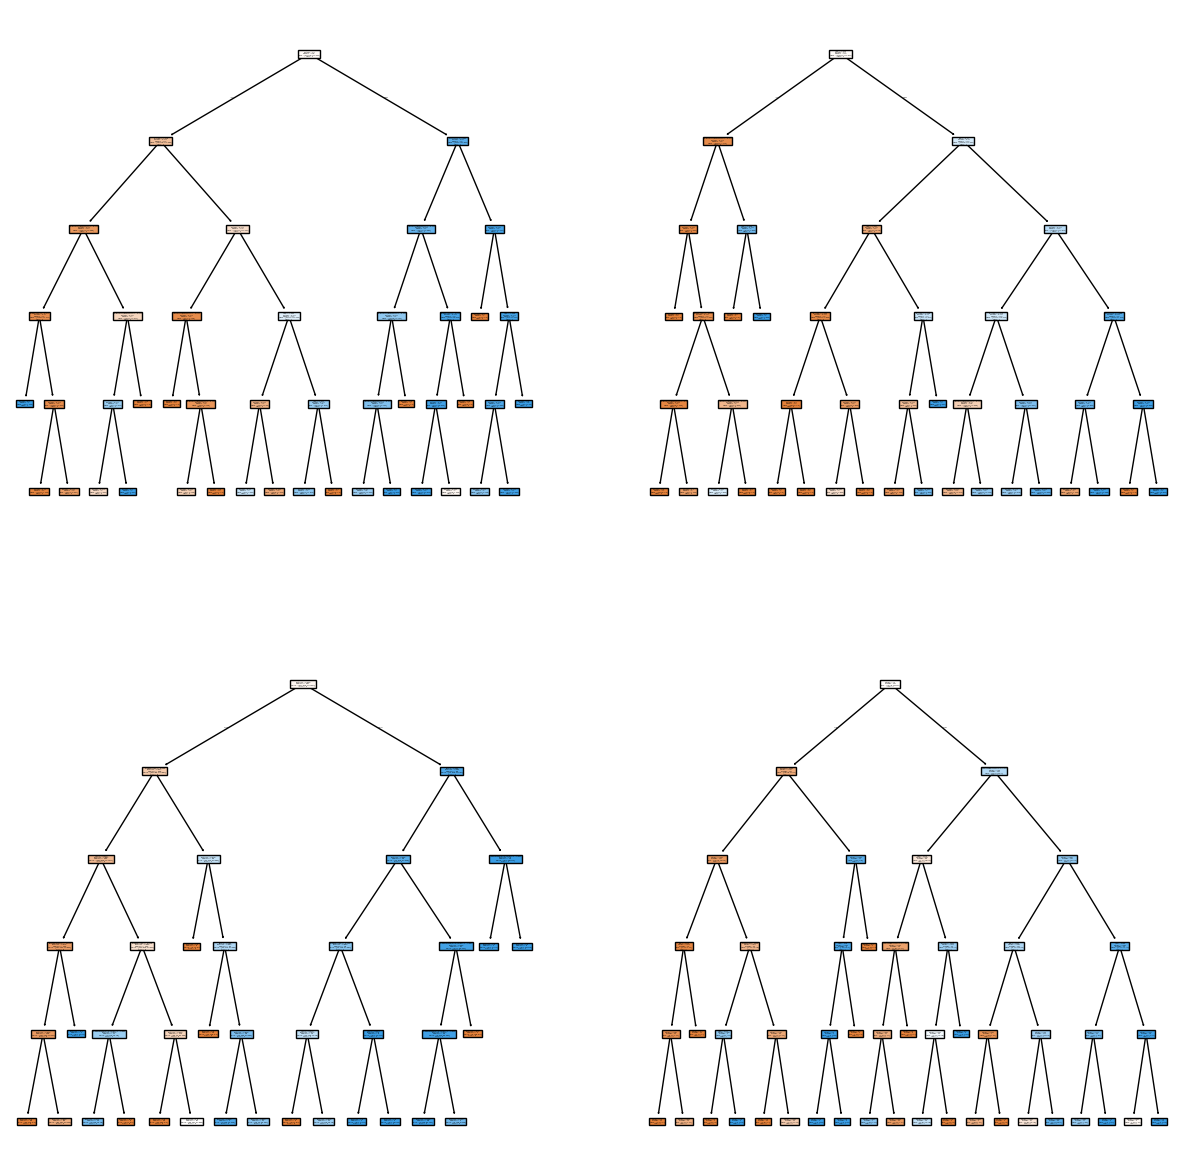

In [27]:
import matplotlib.pyplot as plt
from sklearn import tree

fig, axis = plt.subplots(2, 2, figsize = (15, 15))

# We show the first 4 trees out of the 100 generated (default)
tree.plot_tree(clf_rforest_cv.best_estimator_.named_steps['rforest'][0], ax = axis[0, 0], feature_names = list(X_train.columns), class_names = ["0", "1", "2"], filled = True)
tree.plot_tree(clf_rforest_cv.best_estimator_.named_steps['rforest'][1], ax = axis[0, 1], feature_names = list(X_train.columns), class_names = ["0", "1", "2"], filled = True)
tree.plot_tree(clf_rforest_cv.best_estimator_.named_steps['rforest'][2], ax = axis[1, 0], feature_names = list(X_train.columns), class_names = ["0", "1", "2"], filled = True)
tree.plot_tree(clf_rforest_cv.best_estimator_.named_steps['rforest'][3], ax = axis[1, 1], feature_names = list(X_train.columns), class_names = ["0", "1", "2"], filled = True)

plt.show()

### **5. Model saving**
### **Objective**: Save the model and some critical information we consider necessary


In [32]:
model_dict = {
    'model': clf_rforest_cv.best_estimator_,  # Guardar el mejor estimador del GridSearchCV
    'predictors': X_train.columns.to_list(),
    'target_name': 'Outcome',
    'target_classes': [str(cls) for cls in clf_rforest_cv.classes_], # Guardar los nombres de las clases
    'metrics': {
        'best_f1_weighted': clf_rforest_cv.best_score_, # La mejor puntuación F1 obtenida en CV
        'best_params': clf_rforest_cv.best_params_,   # Los mejores hiperparámetros encontrados
        'accuracy_test': accuracy_score(y_test, y_hat), # Precisión en el conjunto de prueba
        'f1_weighted_test': f1_score(y_test, y_hat, average='weighted'), # F1 ponderado en el conjunto de prueba
        'matthews_corrcoef_test': matthews_corrcoef(y_hat, y_test), # MCC en el conjunto de prueba
        'auc_test': roc_auc_score(y_test, y_hat) if 'predict_proba' in dir(clf_rforest_cv.best_estimator_) else None # AUC en prueba si es clasificador probabilístico
    },
    'Author': 'Kleineer Tabata'
}

with open('random_forest_model.pkl', 'wb') as file:
    pickle.dump(model_dict, file)

print("Información del modelo Random Forest guardada en 'random_forest_model.pkl'")

Información del modelo Random Forest guardada en 'random_forest_model.pkl'
